# ANALYZE BIOMODELS SUBNETS

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tellurium as te
from typing import List

import pySubnetSB.constants as cn
from pySubnetSB.network import Network

# Data Preparation

In [24]:
#PATH = os.path.join(cn.PROJECT_DIR, "biomodels_subnets.csv")
PATH = "/Users/jlheller/Downloads/biomodels_checkpoint.csv"
PATH = os.path.join(cn.DATA_DIR, "biomodels_subnet_strong.csv")
FULL_DF = pd.read_csv(PATH)
FULL_DF.head()

,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated
0,BIOMD0000000191,BIOMD0000000152,NaN,NaN,NaN,NaN,False
1,BIOMD0000000191,BIOMD0000000796,NaN,NaN,NaN,NaN,False
2,BIOMD0000000191,BIOMD0000000794,NaN,NaN,NaN,NaN,False
3,BIOMD0000000191,BIOMD0000000169,NaN,NaN,NaN,NaN,False
4,BIOMD0000000191,BIOMD0000000355,NaN,NaN,NaN,NaN,False


In [25]:
REFERENCE_NAMES = (FULL_DF['reference_name'].unique())
REFERENCE_NAMES.sort()
NUM_REFERENCE = len(REFERENCE_NAMES)
TARGET_NAMES = (FULL_DF['target_name'].unique())
TARGET_NAMES.sort()
NUM_TARGET = len(TARGET_NAMES)
NUM_REFERENCE, NUM_TARGET

(224, 489)

In [26]:
checkDuplicates(FULL_DF)

**No duplicate entries


[]

In [38]:
SUBNET_DF = FULL_DF[FULL_DF['num_assignment_pair'] > 0]
SUBNET_DF = SUBNET_DF.copy()
SUBNET_DF = SUBNET_DF.reset_index()
SUBNET_DF.head()

,index,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated
0,276,BIOMD0000000225,BIOMD0000000320,"BIOMD0000000225: 5 species, 3 reactions\n vgk...","1835503: 5 species, 3 reactions\n benserazide...","{""species_names"": {""G6P_F6P"": ""C1_B"", ""FBP"": ""...",5.0,False
1,556,BIOMD0000000970,BIOMD0000000320,"BIOMD0000000970: 5 species, 3 reactions\n Sus...","415879: 5 species, 3 reactions\n benserazide_...","{""species_names"": {""Susceptible"": ""A_B"", ""Expo...",5.0,False
2,758,BIOMD0000000150,BIOMD0000000064,"BIOMD0000000150: 4 species, 2 reactions\n Bin...","8564038: 4 species, 2 reactions\n vGLK: GLCi ...","{""species_names"": {""CDK2cycA"": ""G6P"", ""CyclinA...",2.0,False
3,765,BIOMD0000000150,BIOMD0000000465,"BIOMD0000000150: 4 species, 2 reactions\n Bin...","2272777: 4 species, 2 reactions\n re60: s16 +...","{""species_names"": {""CDK2cycA"": ""s28"", ""CyclinA...",2.0,False
4,770,BIOMD0000000150,BIOMD0000000602,"BIOMD0000000150: 4 species, 2 reactions\n Bin...","4817335: 4 species, 2 reactions\n R02665: M_3...","{""species_names"": {""CDK2cycA"": ""M_cmusa_c"", ""C...",2.0,False


## Check for duplicates

**REMOVE DUPLICATES**

# Helpers

In [28]:
def makeTestDataFrame():
    df = pd.DataFrame({'reference_name': [0, 1, 1, 2, 2, 2], 'target_name': [0, 1, 1, 2, 2, 2]})
    return df.astype(str)
TEST_NUM_DUPLICATE = 5

In [29]:
def makeAntimony(model_name:str, is_reference:bool=True, is_roadrunner_loadable:bool=False):
    """
    Transforms the string in a "network" cell into an antimony model
    """
    if is_reference:
        name_col = 'reference_name'
        network_col = 'reference_network'
    else:
        name_col = 'target_name'
        network_col = 'induced_network'
    models =  SUBNET_DF[SUBNET_DF[name_col] == model_name][network_col].values
    if len(models) == 0:
        return None
    model = models[0]
    if is_roadrunner_loadable:
        pos = model.index('tions\n')
        model = model[pos+7:]
        model = model.replace('\n', ';1\n')
        model += ";1;"
    return model

# TESTS
model = makeAntimony('BIOMD0000000224', is_roadrunner_loadable=True)
rr = te.loada(model)
model = makeAntimony('BIOMD0000000030')
assert(model is None)
print("OK!")

OK!


In [42]:
def extractBiomodelNum(stg:str)->int:
    """
    Extracts the number from the biomodels name.
    """
    substg = stg[5:]
    pos = np.min([n if c != '0' else 1000 for n, c in enumerate(substg)])
    try:
        result = int(substg[pos:])
    except:
        result = None
    return result

# TESTS
num = extractBiomodelNum('BIOMD0000000030')
assert(num == 30)
num = extractBiomodelNum('BIOMD0000002030')
assert(num == 2030)
print("OK!")

OK!


In [31]:
def checkDuplicates(df:pd.DataFrame, is_print:bool=True)->list:
    """
    Checks if elements are duplicated
    """
    keys = list(df['reference_name'] + df['target_name'])
    duplicates = []
    if len(keys) > len(set(keys)):
        duplicates = [k for k in keys if keys.count(k) > 1]
        if is_print:
            print(f"**Duplicate entries: {duplicates}")
    else:
        if is_print:
            print("**No duplicate entries")
    return duplicates

count = len(checkDuplicates(makeTestDataFrame(), is_print=False))
assert(count == TEST_NUM_DUPLICATE)
print("OK!")

OK!


In [32]:
def removeDuplicates(df:pd.DataFrame)->pd.DataFrame:
    """
    Remove rows where the reference_name + target_name is duplicated.

    Args:
        df: dataframe procesed

    Returns:
        DataFrame w/o duplicates
    """
    keys = np.array(df['reference_name'].astype(str) + df['target_name'].astype(str))
    all_positions = np.array(range(len(keys)))
    drop_idxs = []
    for key in set(keys):
        key_positions = all_positions[keys == key]
        drop_idxs.extend(key_positions[:-1])
    result_df = df.drop(drop_idxs)
    return result_df

# TESTS
df = makeTestDataFrame()
result_df = removeDuplicates(df)
assert(len(result_df) == 3)
print("OK!")   

OK!


In [33]:
def getTargetNames(reference_name:str)->List[str]:
    """
    Gets the list of target names for the reference, if any.

    Args:
       reference_name: str

    Returns:
       list-str
    """
    sel = SUBNET_DF["reference_name"] == reference_name
    if np.sum(sel) == 0:
        return None
    target_names = SUBNET_DF[sel]["target_name"].values
    return target_names

# Tests
names = getTargetNames("BIOMD0000000224")
assert(len(names) > 0)
names = getTargetNames("BIOMD000000022x")
assert(names is None)
print("OK!")

OK!


# Clean Data & Summary Statistics

In [34]:
SUBNET_DF = removeDuplicates(SUBNET_DF)
FULL_DF = removeDuplicates(FULL_DF)

In [43]:
print(f"len(SUBNET_DF)={len(SUBNET_DF)}, len(FULL_DF)={len(FULL_DF)}")
unique_reference = len(FULL_DF["reference_name"].unique())
print(f"unique reference = {unique_reference}")
unique_target = len(FULL_DF["target_name"].unique())
print(f"unique target = {unique_target}")
num_reference_target_pair = unique_reference*unique_target
print(f"num_reference_target_pair={num_reference_target_pair}")

len(SUBNET_DF)=1461, len(FULL_DF)=109536
unique reference = 224
unique target = 489
num_reference_target_pair=109536


# Analysis

Text(0.5, 1.0, 'Strong Identity Subnets in BioModels. Reference model <= 10 Reactions.')

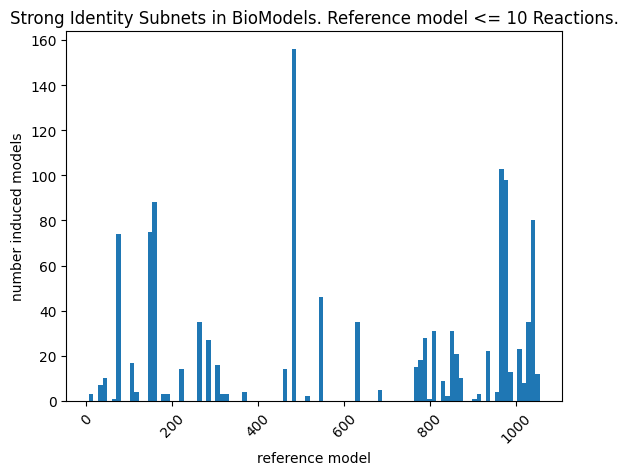

In [45]:
# Number of targets
#if "reference_model" in SUBNET_DF.columns:
#    SUBNET_DF = SUBNET_DF.rename(columns={'reference_model': 'reference_name', 'target_model': 'target_name'})
xvals = [extractBiomodelNum(s) for s in SUBNET_DF['reference_name'] if extractBiomodelNum(s) is not None]
_ = plt.hist(xvals, bins=100)
_ = plt.xticks(rotation=45)
plt.xlabel('reference model')
plt.ylabel('number induced models')
plt.title('Strong Identity Subnets in BioModels. Reference model <= 10 Reactions.')

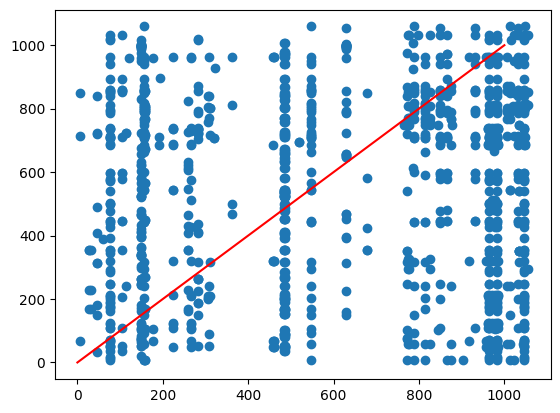

In [46]:
# Scatter plot of subnets
xvals = [extractBiomodelNum(m) for m in SUBNET_DF['reference_name']]
yvals = [extractBiomodelNum(m) for m in SUBNET_DF['target_name']]
plt.scatter(xvals, yvals)
#plt.xlim([0, 300])
#plt.ylim([0, 300])
plt.plot([0,1000], [0, 1000], c='red')

Above the red line are target odels that embed an existing reference model. Below the red line indicate common motif without reuse. The dots below indicate opportunities for reuse.

In [47]:
SUBNET_DF.to_csv("subnet.csv")

In [48]:
# Print all of the reference models that appear in targets
for name in REFERENCE_NAMES:
    result = makeAntimony(name)
    if result is not None:
        print(result + '\n\n')

BIOMD0000000006: 4 species, 3 reactions
  Reaction1: EmptySet -> z
  Reaction2: u -> EmptySet
  Reaction3: z -> u


BIOMD0000000027: 5 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000031: 6 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000047: 2 species, 3 reactions
  Jch: CaER -> Ca_Cyt
  Jleak: CaER -> Ca_Cyt
  Jpump: Ca_Cyt -> CaER


BIOMD0000000060: 4 species, 3 reactions
  Closed_state_1: Po1 -> Pc1
  Open_state_2: Po1 -> Po2
  Closed_State_2: Po1 -> Pc2


BIOMD0000000076: 3 species, 2 reactions
  Gpd_p: DHAP -> G3P
  Gpp_p: G3P -> Gly


BIOMD0000000104: 6 species, 2 reactions
  reaction_0: species_0 -> species_1
  reaction_1: species_1 -> species_4


BIOMD0000000114: 2 species, 4 reactions
  reaction_0000001:  -> y
  reaction_0000002: x -> y
  reaction_0000003: y -> 
  reaction_0000004: x -> y


BIOMD0000000115: 2 species, 5 reactions
  reaction_0000001:  -> y
  reaction_0000002: x -> y
 

# Notes

1. Look for targets with multiple reference submodels.
2. Find interesting plots for paper
3. Do Weak and Strong identities
4. Scatter plot of reference (x) vs. target (y) ordered by BioModels number. Horizontal indicates subnets for same target. Vertical is targets for same reference.